In [1]:
# Compare star magnitudes calculated on CFHT images with LSST stack to those extracted from SDSS catalog
# Original code from Simon Krughoff (U. Washington)

%matplotlib inline
import matplotlib
import matplotlib.pylab as plt

from lsst.meas.astrom import Astrometry
import lsst.daf.persistence as dafPersist
import lsst.afw.geom as afwGeom
import lsst.afw.cameraGeom as cg
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage
import lsst.afw.display.ds9 as ds9
import numpy
import math

#visit = 906805
#visit = 906675
#visit = 918231
visit = 912206
filter = 'r'

Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         "base_PsfFlux_flag_edge"]

#setup astrometry solver
solve = Astrometry.ConfigClass()
astrom = Astrometry(solve)

#setup butler - It assumes that a standard LSST directory structure is setup at the upper directory level
butler = dafPersist.Butler('../output')

# setup camera
cam = butler.get('camera')
ccd14 = cam['ccd14']
vId = {'visit':visit, 'ccd':14}
calexp = butler.get("calexp", vId, immediate=True)
detCenter = ccd14.getCenter(cg.PIXELS).getPoint()
detCenterCoord = calexp.getWcs().pixelToSky(detCenter)
refCat = astrom.getReferenceSources(detCenterCoord.getLongitude(), detCenterCoord.getLatitude(), 
                                    afwGeom.Angle(1., afwGeom.degrees), filter)

def mkmag(flux):
    return -2.5*math.log(flux)/math.log(10.)


diffpsf = []
diffnaive = []
diffsinc = []
mags = []
mag_center = []
mag_border = []
diffpsf_center = []
diffpsf_border = []
ccdNum = []
xCoord = []
yCoord = []
errs = [] # Error on PSF mag

# Will compute magnitudes separately for CDD located in the center and on the border of the focal plane
center = [11, 12, 13, 14, 15, 20, 21, 22, 23, 24]
border = [0, 1, 2, 3, 4, 5, 6, 7, 8, 17, 26, 35, 34, 33, 32, 31, 30, 29, 28, 27, 18, 9]

for ccd in range(0,36) :
    vId = {'visit':visit,'ccd':ccd}
    src = butler.get('src', vId, immediate=True)
    # calexp_md : metadata
    md = butler.get("calexp_md", vId, immediate=True)
    calib = afwImage.Calib(md)
    match = afwTable.matchRaDec(refCat, src, afwGeom.Angle(1./3600., afwGeom.degrees))
    count = 0
    open = 0
    for m in match:
        rej = 0
        for f in Flags :
            if m.second.get(f) :
                rej = 1
                break
        if rej == 1 :
            continue
        if not m.first.get("photometric") :
            print "Not photometric"
            continue
        signalToNoise = m.second.get("base_SincFlux_flux")/m.second.get("base_SincFlux_fluxSigma")
        if signalToNoise < 5.0 :
#            print "Low SNR :", signalToNoise
            continue
        if m.second.get('base_ClassificationExtendedness_value') < 0.5:
            # Correct magnitude to take into account the different filter sets in SDSS and CFHT
            # Ref : http://www3.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/community/CFHTLS-SG/docs/extra/filters.html
            # Another color correction is given in : 
            # http://www1.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/community/CFHTLS-SG/docs/cfhtls.pdf
            if filter == 'u' :
                mag = mkmag(m.first.get('u')) - 0.241*(mkmag(m.first.get('u')) - mkmag(m.first.get('g')))
            elif filter == 'i' :
               mag = mkmag(m.first.get('i')) - 0.085*(mkmag(m.first.get('r')) - mkmag(m.first.get('i')))
            elif filter == 'r' :
                mag = mkmag(m.first.get('r')) - 0.024*(mkmag(m.first.get('g')) - mkmag(m.first.get('r')))
            elif filter == 'g' :
                mag = mkmag(m.first.get('g')) - 0.153*(mkmag(m.first.get('g')) - mkmag(m.first.get('r')))
#                mag = mkmag(m.first.get('r')) - 0.030*(mkmag(m.first.get('r')) - mkmag(m.first.get('i')))
            magPsf, errPsf = calib.getMagnitude(m.second.get('base_PsfFlux_flux'),m.second.get('base_PsfFlux_fluxSigma'))
            if mag < 15.0 or magPsf < 15 or math.fabs(mag - calib.getMagnitude(m.second.get('base_PsfFlux_flux'))) > 2.0 :
                print mag, magPsf, mag - calib.getMagnitude(m.second.get('base_PsfFlux_flux'))
                continue
            diffpsf.append(mag - calib.getMagnitude(m.second.get('base_PsfFlux_flux')))
            diffnaive.append(mag - calib.getMagnitude(m.second.get('base_NaiveFlux_flux')))
            diffsinc.append(mag - calib.getMagnitude(m.second.get('base_SincFlux_flux')))
            mags.append(mag)
            errs.append(errPsf)
            
            x = m.second.getCentroid().getX()
            y = m.second.getCentroid().getY()
            xCoord.append(x)
            yCoord.append(y)
            
            delta = calib.getMagnitude(m.second.get('base_PsfFlux_flux'))-calib.getMagnitude(m.second.get('base_SincFlux_flux'))
            if mag < 19 and math.fabs(delta) > 0.1 :
                print visit, ccd, delta
                cal = butler.get("calexp", vId, immediate=True)
                if open == 0 :
#                    ds9.mtv(cal.getMaskedImage().getImage(), frame=ccd+1, wcs=cal.getWcs())
                    open =1
#                with ds9.Buffering():
#                    ds9.dot('+', x, y, frame=ccd+1, size=10)
            
            ccdNum.append(ccd)
            
            if ccd in center :
                mag_center.append(mag)
                diffpsf_center.append(mag - calib.getMagnitude(m.second.get('base_PsfFlux_flux')))
            if ccd in border :
                mag_border.append(mag)
                diffpsf_border.append(mag - calib.getMagnitude(m.second.get('base_PsfFlux_flux')))
                
            count += 1
#    print "ccd : ",ccd," number of matches :",count
print "Total number of matches :", len(mags)

KeyError: "Field 'base_SincFlux_flux' not found in Schema."

In [28]:
print refCat
schema = src.getSchema()
print schema.getOrderedNames()
print src[1].get("coord") 
print src[1].get("base_GaussianCentroid_x"), src[1].get("base_GaussianCentroid_y")
print src[1].getCentroid()
print dir(src[0])


<lsst.afw.table.tableLib.SimpleCatalog; proxy of <Swig Object of type 'lsst::afw::table::SortedCatalogT< lsst::afw::table::SimpleRecord > *' at 0x56951b0> >
('id', 'coord', 'parent', 'calib_detected', 'calib_psfCandidate', 'calib_psfUsed', 'flags_negative', 'base_GaussianCentroid_x', 'base_GaussianCentroid_y', 'base_GaussianCentroid_flag', 'base_GaussianCentroid_flag_noPeak', 'base_NaiveCentroid_x', 'base_NaiveCentroid_y', 'base_NaiveCentroid_flag', 'base_NaiveCentroid_flag_noCounts', 'base_NaiveCentroid_flag_edge', 'base_PixelFlags_flag', 'base_PixelFlags_flag_edge', 'base_PixelFlags_flag_interpolated', 'base_PixelFlags_flag_interpolatedCenter', 'base_PixelFlags_flag_saturated', 'base_PixelFlags_flag_saturatedCenter', 'base_PixelFlags_flag_cr', 'base_PixelFlags_flag_crCenter', 'base_PixelFlags_flag_bad', 'base_SdssCentroid_x', 'base_SdssCentroid_y', 'base_SdssCentroid_xSigma', 'base_SdssCentroid_ySigma', 'base_SdssCentroid_x_y_Cov', 'base_SdssCentroid_flag', 'base_SdssCentroid_flag_ed

In [ ]:
def plotMag(mags, diff, xrange, yrange):
    plt.scatter(mags, diff)
    plt.xlabel("r")
    plt.ylabel("$\Delta$ r")
    plt.xlim(xrange)
    plt.ylim(yrange)
    plt.suptitle(" ")

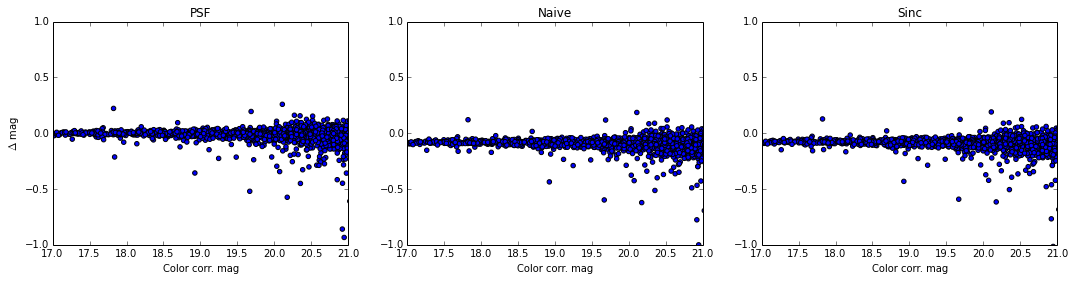

In [12]:
plt.clf()
xrange=[17., 21.]
yrange=[-1.,1.]
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(18, 4))
ax0.scatter(mags,diffpsf)
ax1.scatter(mags,diffnaive)
ax2.scatter(mags,diffsinc)
ax0.set_xlim(xrange)
ax0.set_ylim(yrange)
ax0.set_ylabel("$\Delta$ mag")
ax0.set_xlabel("Color corr. mag")
ax0.set_title("PSF")
ax1.set_xlim(xrange)
ax1.set_ylim(yrange)
ax1.set_xlabel("Color corr. mag")
ax1.set_title("Naive")
ax2.set_xlim(xrange)
ax2.set_ylim(yrange)
ax2.set_xlabel("Color corr. mag")
ax2.set_title("Sinc")

plt.show()

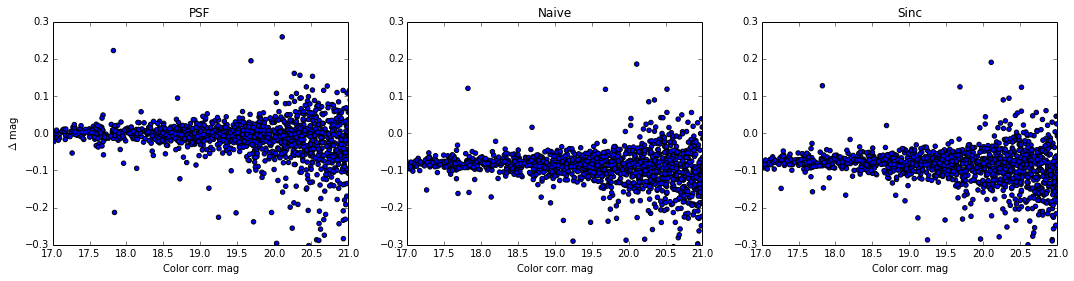

In [13]:
plt.clf()
xrange=[17., 21.]
yrange=[-0.3,0.3]
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(18, 4))
ax0.scatter(mags,diffpsf)
ax1.scatter(mags,diffnaive)
ax2.scatter(mags,diffsinc)
ax0.set_xlim(xrange)
ax0.set_ylim(yrange)
ax0.set_ylabel("$\Delta$ mag")
ax0.set_xlabel("Color corr. mag")
ax0.set_title("PSF")
ax1.set_xlim(xrange)
ax1.set_ylim(yrange)
ax1.set_xlabel("Color corr. mag")
ax1.set_title("Naive")
ax2.set_xlim(xrange)
ax2.set_ylim(yrange)
ax2.set_xlabel("Color corr. mag")
ax2.set_title("Sinc")

plt.show()

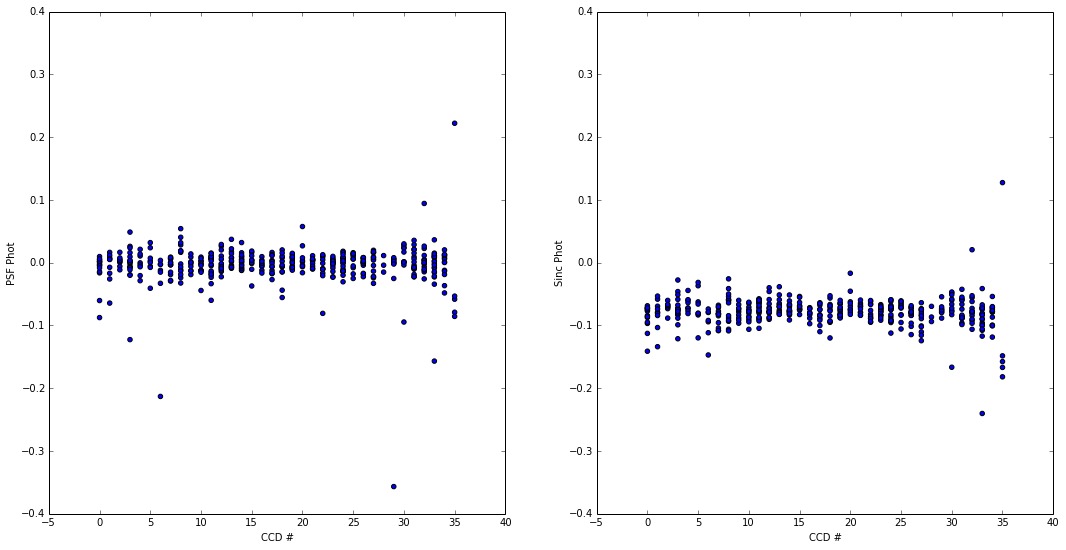

In [16]:
plt.clf()
magmax=19
idxs = numpy.where(numpy.asarray(mags) < magmax)
diffpsf2 = numpy.asarray(diffpsf)
diffsinc2 = numpy.asarray(diffsinc)
ccdNum2 = numpy.asarray(ccdNum)
yrange=[-0.4,0.4]
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(18, 9))
ax0.scatter(ccdNum2[idxs],diffpsf2[idxs])
ax1.scatter(ccdNum2[idxs],diffsinc2[idxs])
ax0.set_ylabel("PSF Phot")
ax0.set_xlabel("CCD #")
ax1.set_ylabel("Sinc Phot")
ax1.set_xlabel("CCD #")
ax0.set_ylim(yrange)
ax1.set_ylim(yrange)

plt.show()

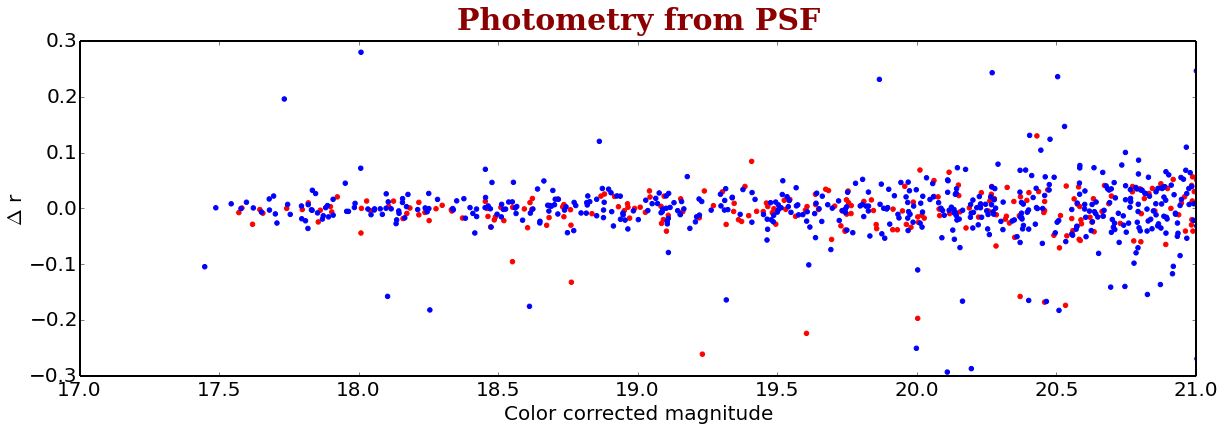

In [49]:
# Compare CFHT to SDSS magnitude for CCD located in the center and on the border of the focal plane

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 30,
        }

plt.clf()
plt.rcParams['axes.linewidth'] = 2
fig, (ax0) = plt.subplots(ncols=1, figsize=(20, 6))
ax0.scatter(mag_center, diffpsf_center, color='red')
ax0.scatter(mag_border, diffpsf_border, color='blue')
ax0.set_xlabel("Color corrected magnitude", fontsize=20)
ax0.set_ylabel("$\Delta$ r", fontsize=20)
ax0.set_xlim([17,21])
ax0.set_ylim([-0.3,0.3])
ax0.set_title("Photometry from PSF", fontdict=font, y=1.02)
ax0.tick_params(labelsize=20)
plt.show()

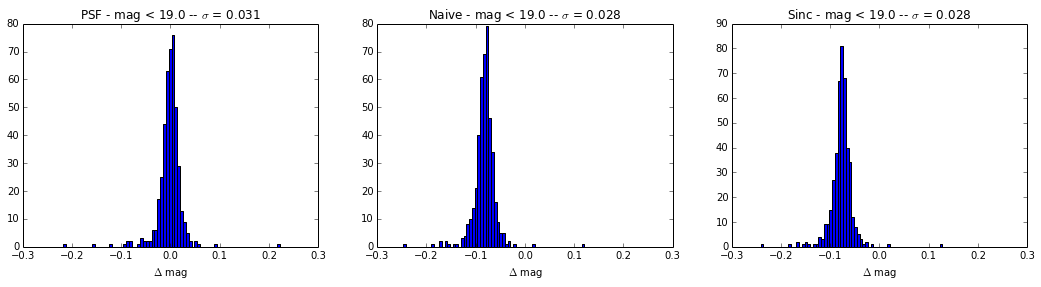

In [15]:
magmax = 19.
idxs = numpy.where(numpy.asarray(mags) < magmax)
diffpsf = numpy.asarray(diffpsf)
diffnaive = numpy.asarray(diffnaive)
diffsinc = numpy.asarray(diffsinc)

plt.clf()
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(18, 4))
ax0.hist(diffpsf[idxs], bins=100)
ax0.set_xlabel("$\Delta$ mag")
ax0.set_xlim([-0.3, 0.3])
ax0.set_title("PSF - mag < %.1f -- $\sigma$ = %.3f"%(magmax, numpy.std(diffpsf[idxs])))

ax1.hist(diffnaive[idxs], bins=100)
ax1.set_xlabel("$\Delta$ mag")
ax1.set_xlim([-0.3, 0.3])
ax1.set_title("Naive - mag < %.1f -- $\sigma$ = %.3f"%(magmax, numpy.std(diffnaive[idxs])))

ax2.hist(diffsinc[idxs], bins=100)
ax2.set_xlabel("$\Delta$ mag")
ax2.set_xlim([-0.3, 0.3])
ax2.set_title("Sinc - mag < %.1f -- $\sigma$ = %.3f"%(magmax, numpy.std(diffsinc[idxs])))

plt.show()

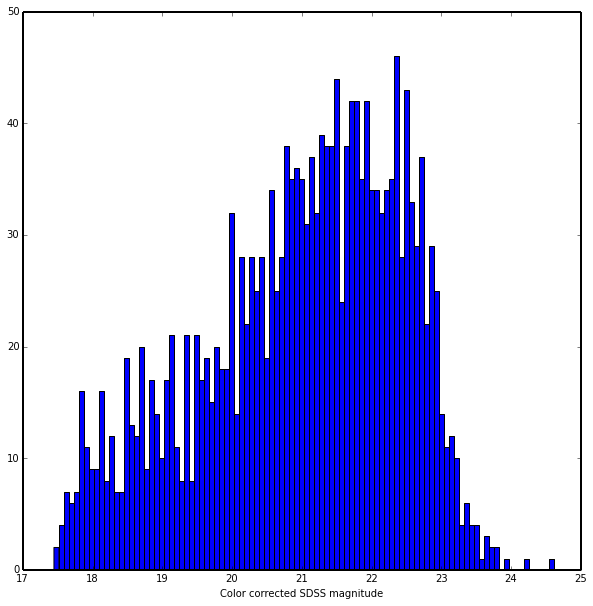

In [44]:
plt.clf()
fig, (ax0) = plt.subplots(ncols=1, figsize=(10, 10))
ax0.hist(mags, bins=100)
ax0.set_xlabel("Color corrected SDSS magnitude")
plt.show()

Mean value : -0.0787950994783


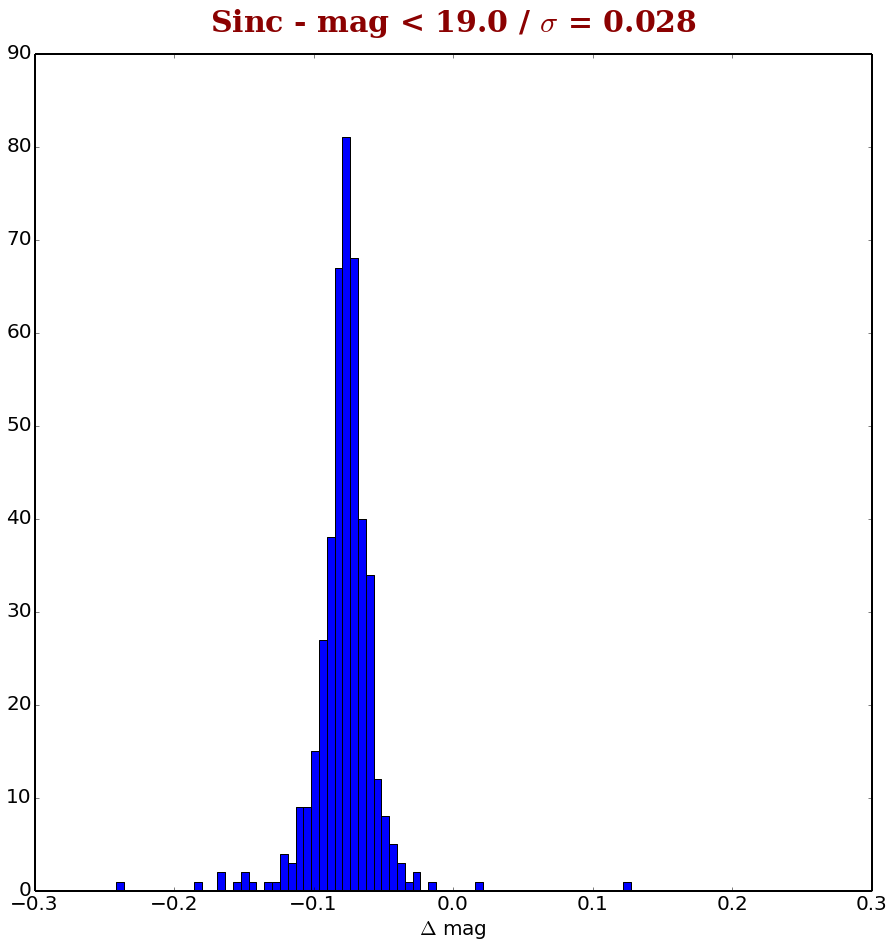

In [66]:
magmax = 19.
idxs = numpy.where(numpy.asarray(mags) < magmax)
diffpsf = numpy.asarray(diffpsf)
diffnaive = numpy.asarray(diffnaive)
diffsinc = numpy.asarray(diffsinc)

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 30,
        }

plt.clf()
plt.rcParams['axes.linewidth'] = 2
fig, (ax0) = plt.subplots(ncols=1, figsize=(15, 15))
#ax0.hist(diffpsf[idxs], bins=100)
#ax0.hist(diffnaive[idxs], bins=100)
ax0.hist(diffsinc[idxs], bins=100)
ax0.set_xlabel("$\Delta$ mag", fontsize=20)
ax0.set_xlim([-0.3, 0.3])
ax0.tick_params(labelsize=20)
ax0.set_title("Sinc - mag < %.1f / $\sigma$ = %.3f"%(magmax, numpy.std(diffsinc[idxs])), fontdict=font, y=1.02)

print "Mean value :", numpy.mean(diffsinc[idxs])

### Compare PSF flux to aperture flux

(0.001, 0.0026)

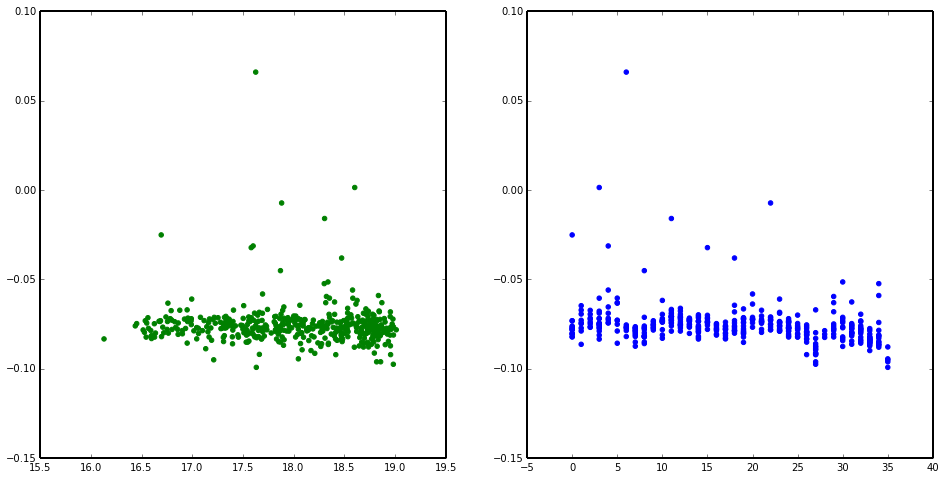

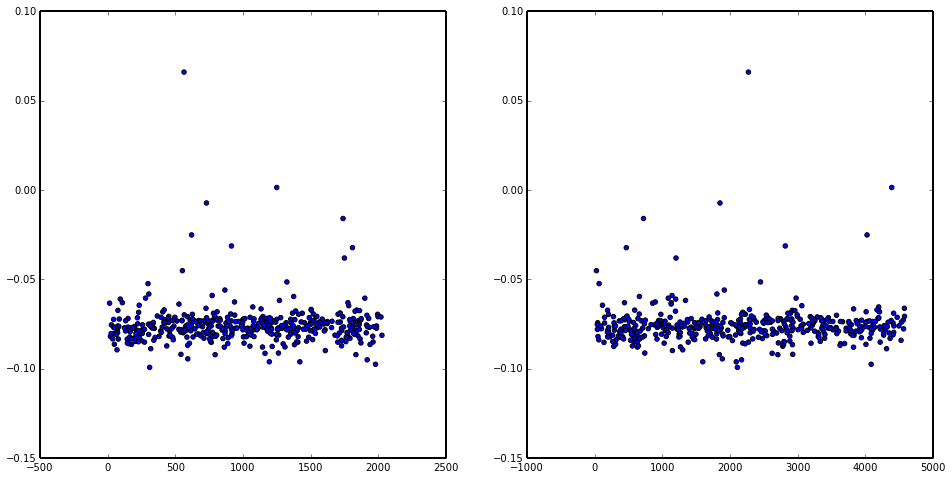

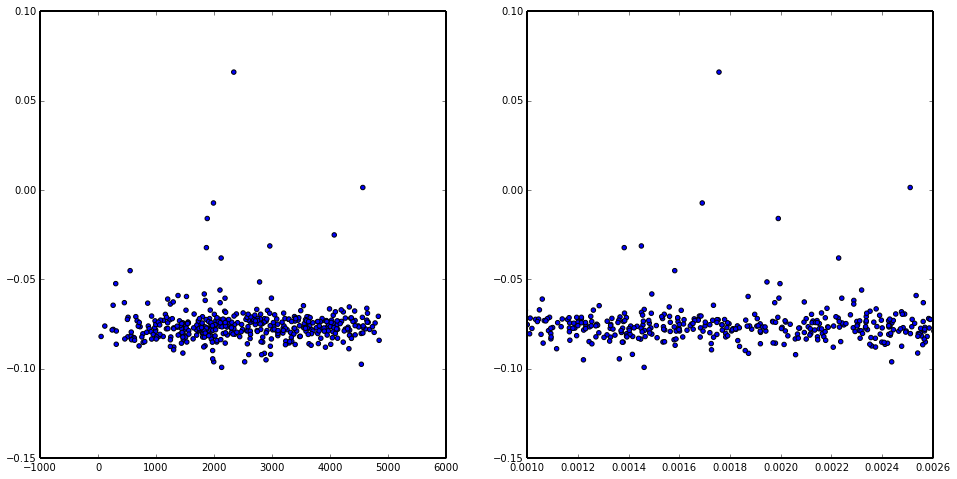

In [17]:
magmax = 19

idxs = numpy.where(numpy.asarray(mags) < magmax)
psf = numpy.asarray(diffpsf+mags)
sinc = numpy.asarray(diffsinc+mags)
ccdNum = numpy.asarray(ccdNum)
xCoord = numpy.asarray(xCoord)
yCoord = numpy.asarray(yCoord)
errs = numpy.asarray(errs)

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 30,
        }

plt.clf()
plt.rcParams['axes.linewidth'] = 2
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 8))
ax0.scatter(psf[idxs], sinc[idxs]-psf[idxs], color='g')
ax1.scatter(ccdNum[idxs], sinc[idxs]-psf[idxs], color='b')
fig, (ax2, ax3) = plt.subplots(ncols=2, figsize=(16, 8))
ax2.scatter(xCoord[idxs], sinc[idxs]-psf[idxs])
ax3.scatter(yCoord[idxs], sinc[idxs]-psf[idxs])
fig, (ax4, ax5) = plt.subplots(ncols=2, figsize=(16, 8))
ax4.scatter(numpy.sqrt(xCoord[idxs]**2+yCoord[idxs]**2), sinc[idxs]-psf[idxs])
ax5.scatter(errs[idxs], sinc[idxs]-psf[idxs])
ax5.set_xlim([0.0010, 0.0026])

### Check if there is some color dependency on delta(mag)

In [ ]:
from lsst.meas.astrom import Astrometry
import lsst.daf.persistence as dafPersist
import lsst.afw.cameraGeom as cg
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable
import math

def getMagnitude(butler, mRef, visit, filter) :
    # retrieve the CCD corresponding to the reference source
    ccdRef = mRef.get('ccd')
    # retrieve the calibration object associated to the CCD
    did = {'visit':visit, 'filter':filter, 'ccd':ccdRef}
    md = butler.get("calexp_md", did, immediate=True)
    calib = afwImage.Calib(md)
    # compute magnitude
    flux = mRef.get('base_PsfFlux_flux')
#    flux = mRef.get('base_SincFlux_flux')
#    flux = mRef.get('base_GaussianFlux_flux')
    if flux > 0.0 :
        return calib.getMagnitude(flux)
    else :
        return 99

def createFullFPCatalog(butler, visit, filter) :

    for ccd in range(36) :
        dataid = {'visit':visit, 'filter':filter, 'ccd':ccd}
        oldSrc = butler.get('src', dataid, immediate=True)
#        print ccd, len(oldSrc)
        if ccd == 0 :
            # retrieve the schema of the source catalog and extend it in order to add a field to record the ccd number
            oldSchema = oldSrc.getSchema()
            mapper = afwTable.SchemaMapper(oldSchema)
            mapper.addMinimalSchema(oldSchema)
            newSchema = mapper.getOutputSchema()
            newSchema.addField("ccd", type=int, doc="CCD number")
            
            #create the new extented source catalog 
            srcRef = afwTable.SourceCatalog(newSchema)
        
        # create temporary catalog
        tmpCat = afwTable.SourceCatalog(srcRef.table)
        tmpCat.extend(oldSrc, mapper=mapper)
        # fill in the ccd information in numpy mode in order to be efficient
        tmpCat['ccd'][:] = ccd
        # append the temporary catalog to the extended source catalog    
        srcRef.extend(tmpCat, deep=False)
    
    return srcRef

def mkmag(flux):
    return -2.5*math.log(flux)/math.log(10.)

#visit_r = 850587
# visit_r = 906675

# Be careful, this is u not r
visit_r = 906675

visit_g = 918231

filter = "r"

Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         "base_PsfFlux_flag_edge"]

#setup butler - Replace path name by something suitable for you
butler = dafPersist.Butler("/home/boutigny/CFHT/test_cfht/output")

# Assemble all CCD in 1 big afw table extended in such a way to keep track of the CCD number
src_r = createFullFPCatalog(butler, visit_r, filter)
print len(src_r), " r sources"
src_g = createFullFPCatalog(butler, visit_g, 'g')
print len(src_g), "g sources"
 
#setup astrometry solver
solve = Astrometry.ConfigClass()
astrom = Astrometry(solve)

# setup camera and get the astrometry catalog corresponding to the region of interest
cam = butler.get('camera')
ccd14 = cam['ccd14']
vId = {'visit':visit_r, 'ccd':14}
calexp = butler.get("calexp", vId, immediate=True)
detCenter = ccd14.getCenter(cg.PIXELS).getPoint()
detCenterCoord = calexp.getWcs().pixelToSky(detCenter)
refCat_r = astrom.getReferenceSources(detCenterCoord.getLongitude(), detCenterCoord.getLatitude(), afwGeom.Angle(1., afwGeom.degrees), filter)
refCat_g = astrom.getReferenceSources(detCenterCoord.getLongitude(), detCenterCoord.getLatitude(), afwGeom.Angle(1., afwGeom.degrees), 'g')

match_r = afwTable.matchRaDec(refCat_r, src_r, afwGeom.Angle(1./3600., afwGeom.degrees))
match_g = afwTable.matchRaDec(refCat_g, src_g, afwGeom.Angle(1./3600., afwGeom.degrees))

print len(match_r), "r matches in reference catalog" 
print len(match_g), "g matches in reference catalog" 

deltaMag = []
gMinusr = []
mags = []
ccd = []

for m_r in match_r :
    rej = 0
    if m_r.second.get('base_ClassificationExtendedness_value') > 0.5 :
        continue
    for f in Flags :
        if m_r.second.get(f) :
            rej = 1
            break
    if rej == 1 :
        continue
    id = m_r.first.getId()
    mag_r = getMagnitude(butler, m_r.second,visit_r,filter)
    ccd_r = m_r.second.get('ccd')
    if filter == "r" :
        mag_ref = mkmag(m_r.first.get('r')) - 0.024*(mkmag(m_r.first.get('g')) - mkmag(m_r.first.get('r')))
        #mag_ref = mkmag(m_r.first.get('r')) - 0.018*(mkmag(m_r.first.get('g')) - mkmag(m_r.first.get('r')))
    if filter == "u" :
        mag_ref = mkmag(m_r.first.get('u')) - 0.241*(mkmag(m_r.first.get('u')) - mkmag(m_r.first.get('g')))
    for m_g in match_g :
        if m_g.first.getId() == id : 
            mag_g = getMagnitude(butler, m_g.second,visit_g,'g')
            deltaMag.append(mag_ref-mag_r)
            gMinusr.append(mag_g-mag_r)
            mags.append(mag_r)
            ccd.append(ccd_r)
            break
            
print "Number of r, g, ref matches :", len(deltaMag)

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy


font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 20,
        }

magmax = 19.
mags = numpy.asarray(mags)
deltaMag = numpy.asarray(deltaMag)
gMinusr = numpy.asarray(gMinusr)
ccd = numpy.asarray(ccd)

#idxs = numpy.where((mags < magmax) & (gMinusr < 2))
idxs = numpy.where((mags < magmax))

plt.clf()
plt.rcParams['axes.linewidth'] = 2
fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(20, 15))
ax0.scatter(gMinusr[idxs], deltaMag[idxs])
ax0.set_xlabel("mag(g)-mag(r)", fontsize=20)
ax0.set_ylabel("$\Delta$ mag", fontsize=20)
ax0.set_xlim([-0.1,1.5])
ax1.hist(deltaMag[idxs], bins=100)
ax1.set_xlim([-0.3, 0.3])
ax1.set_xlabel("$\Delta$ mag", fontsize=20)
ax1.tick_params(labelsize=20)
ax1.set_title("PSF - mag < %.1f / $\sigma$ = %.3f"%(magmax, numpy.std(deltaMag[idxs])), fontdict=font, y=1.02)
plt.show()

plt.clf()
fig, (ax2) = plt.subplots(ncols=1, figsize=(15, 15))
ax2.scatter(ccd[idxs], deltaMag[idxs])
ax2.set_ylim([-0.25, 0.25])
ax2.set_xlabel("CCD #", fontsize=20)
ax2.set_ylabel("$\Delta$ mag", fontsize=20)

print "Sigma :", numpy.std(deltaMag[idxs])
plt.show()

In [ ]:
from scipy.optimize import curve_fit

def gauss(x, *p):
    A, mu, sigma = p
    return A*numpy.exp(-(x-mu)**2/(2.*sigma**2))

hist, bin_edges = numpy.histogram(deltaMag[idxs],bins=30)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

p0 = [35., 0., 0.025]

coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
hist_fit = gauss(bin_centres, *coeff)

plt.clf()
fig, (ax0) = plt.subplots(ncols=1, figsize=(15, 15))
ax0.plot(bin_centres, hist, 'r+', label='Test data', ms=15)
#ax0.plot(bin_centres, hist_fit, 'bo', label='Fitted data')
ax0.tick_params(labelsize=20)
ax0.set_xlabel("$\Delta$ mag", fontsize=20)

x = numpy.linspace(-0.15, 0.10, num=200)
ax0.plot(x,gauss(x,*coeff), lw=2)

print 'Fitted mean = ', coeff[1]
print 'Fitted standard deviation = ', coeff[2]

plt.show()